In [1]:
import numpy as np
import h5py
import time
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
# This function is basically the same function as in /QMMeltpool DataPrep/helping_functions.py but without the intensity filter

def getting_2D_data_from_h5_filtered_np_xy_switched_without_intensity_filter(h5_path, part_name, slice_name,  show_info=False):

    # setting the start timer for time information
    start_time = time.time()

    # opening HDF5 file
    with h5py.File(h5_path, 'r') as h5:

        # check whether slice exists -> if not: empty array returned
        if slice_name in h5[part_name]:
            # X and Y Axis are changed to fit the OpenCV coordinate system
            X_Axis = np.array(h5[part_name][slice_name]['Y-Axis'][:]).astype(int)
            Area = np.array(h5[part_name][slice_name]['Area'][:]).astype(int)
            Intensity = np.array(h5[part_name][slice_name]['Intensity'][:]).astype(int)
            Y_Axis = np.array(h5[part_name][slice_name]['X-Axis'][:]).astype(int)

            # The following if condition is added because pre investigations showed that in some very rare cases
            # the dimensions of the arrays weren't exactly the same as there was an extra point on top of one of the
            # arrays. The dimension inequality led to instabilities.
            # If dimensions aren't equal the following code block is entered

            if not X_Axis.size == Y_Axis.size == Area.size == Intensity.size:

                # determine the lowest value among the different sizes
                size_arr = np.array([X_Axis.size, Y_Axis.size, Area.size, Intensity.size])
                min_size = size_arr.min()

                if X_Axis.size != min_size:
                    diff_size_x = X_Axis.size - min_size
                    X_Axis = np.delete(X_Axis, -diff_size_x)

                if Y_Axis.size != min_size:
                    diff_size_y = Y_Axis.size - min_size
                    Y_Axis = np.delete(Y_Axis, -diff_size_y)

                if Area.size != min_size:
                    diff_size_area = Area.size - min_size
                    Area = np.delete(Area, -diff_size_area)

                if Intensity.size != min_size:
                    diff_size_intensity = Intensity.size - min_size
                    Intensity = np.delete(Intensity, -diff_size_intensity)

            if show_info:
                print(str(X_Axis.size) + ' total data points found')

            # The following line of code stacks the single arrays to a table like structure.
            combos = np.stack((X_Axis, Y_Axis, Area, Intensity), axis=-1)

            # The following block filters out single outlier points by comparing the X and Y-values to min and max
            # values.
            median_x = np.median(combos[:, 0])
            median_y = np.median(combos[:, 1])
            std_x = int(combos[:, 0].std())
            std_y = int(combos[:, 1].std())
            low_limit_x = median_x - 2 * std_x
            low_limit_y = median_y - 2 * std_y
            high_limit_x = median_x + 2 * std_x
            high_limit_y = median_y + 2 * std_y

            combos = np.delete(combos, np.where(combos[:, 0] < low_limit_x), axis=0)
            combos = np.delete(combos, np.where(combos[:, 0] > high_limit_x), axis=0)
            combos = np.delete(combos, np.where(combos[:, 1] < low_limit_y), axis=0)
            combos = np.delete(combos, np.where(combos[:, 1] > high_limit_y), axis=0)

            # The following block filters out points where Area and Intensity values are equal to 0.
            area_zeros = np.where(combos[:, 2] == 0)
            intensity_zeros = np.where(combos[:, 3] == 0)
            zero_area_intensity_indices = np.intersect1d(area_zeros, intensity_zeros)
            combos_wo_only_zeros = np.delete(combos, zero_area_intensity_indices, axis=0)

            if show_info:
                print(str(combos_wo_only_zeros.shape[0]) + ' data points where area != 0 AND intensity != 0')

            # The following block is used for handling x,y-combinations occurring multiple times
            _, unique_indices = np.unique(combos_wo_only_zeros[:, [0, 1]], axis=0, return_index=True)
            combos_unique = combos_wo_only_zeros[unique_indices]

            if show_info:
                print(str(combos_unique.shape[0]) + ' unique x,y-combinations where area != 0 AND intensity != 0')

            # getting all the indices belonging to non unique x,y-combinations
            index_range = np.arange(combos_wo_only_zeros.shape[0])
            indices_of_interest = np.setdiff1d(index_range, unique_indices)

            combo_processed_array = np.empty([0, 4], dtype=int)
            return_array = np.copy(combos_wo_only_zeros)
            index_counter = 0
            indices_list = []

            if show_info:
                print("vor iterieren %s seconds ---" % (time.time() - start_time))

            # looping through all the indices belonging to non unique x,y-combinations
            for index in indices_of_interest:
                xy_combo = combos_wo_only_zeros[:, [0, 1]][index]
                # checking whether x,y combination has already been checked, if yes -> no action
                if np.where((combo_processed_array[:, 0] == xy_combo[0]) * (combo_processed_array[:, 1] == xy_combo[1]))[0].size == 0:
                    index_counter += 1
                    xy_combo = combos_wo_only_zeros[:, [0, 1]][index]

                    # getting all the indices of the currently checked x,y-combination
                    indices_relevant = np.where((combos_wo_only_zeros[:, 0] == xy_combo[0]) * (combos_wo_only_zeros[:, 1] == xy_combo[1]))[0]

                    # getting the max Area and Intensity of the currently checked x,y-combination
                    # this block would need to be replaced in case mean values are desired
                    max_area_of_combo = np.amax(combos_wo_only_zeros[:, 2][indices_relevant])
                    max_intensity_of_combo = np.amax(combos_wo_only_zeros[:, 3][indices_relevant])

                    # stacking x, y, maxArea and maxIntensity together
                    max_combos = np.stack((xy_combo[0], xy_combo[1], max_area_of_combo, max_intensity_of_combo), axis=-1)

                    # stacking the created combination on top of the copy of combos_wo_only_zeros
                    return_array = np.vstack((return_array, max_combos))

                    # adding the relevant indices to the indices_list and adding the created combination to combo_processed_array
                    indices_list.append(list(indices_relevant))
                    combo_processed_array = np.vstack((combo_processed_array, max_combos))

            # creating a an array with all the indices of multiple points and deleting those positions from combos_
            # wo_only_zeros_copy -> this way all the old x,y combinations occurring multiple times are replaced by the
            # generated combination with max Values
            indices_relevant = np.hstack(indices_list)
            return_array = np.delete(return_array, indices_relevant, axis=0)

        else:
            return_array = np.empty([0, 4], dtype=int)
            print('{} is not existing -> empty array created'.format(slice_name))

        if show_info:
            print("array creation took %s seconds ---" % (time.time() - start_time))

    return return_array

In [3]:
def get_min_max_values_xy_changed_small_diameter (h5_path, part_name,  min_slice_num, max_slice_num):
    df = pd.DataFrame(columns=['Slice_num', 'minX', 'maxX', 'minY', 'maxY', 'diameterX', 'diameterY'])

    for num_slice in range(min_slice_num, max_slice_num+1):
        if num_slice != 1292: # change made because of outlier point in ZP3 - shouldn't affect the other values
            slice_name = 'Slice' + str("{:05d}".format(num_slice))

            array = getting_2D_data_from_h5_filtered_np_xy_switched_without_intensity_filter(h5_path, part_name, slice_name)
            minX = array[:, 0].min()
            maxX = array[:, 0].max()
            minY = array[:, 1].min()
            maxY = array[:, 1].max()
            diameterX = maxX - minX
            diameterY = maxY - minY

            df = df.append({'Slice_num': "{:05d}".format(num_slice), 'minX': minX, 'maxX': maxX, 'minY': minY, 'maxY': maxY,
                            'diameterX': diameterX, 'diameterY': diameterY}, ignore_index=True)

    return df['minX'].min(), df['minY'].min(), df['maxX'].max(), df['maxY'].max()



def dock_array_to_zero(array, minX, minY):
    if minX >= 0 and minY >= 0:
        array[:, 0] = array[:, 0] - minX
        array[:, 1] = array[:, 1] - minY
    elif minX < 0 and minY < 0:
        array[:, 0] = array[:, 0] + abs(minX)
        array[:, 1] = array[:, 1] + abs(minY)
    elif minX >= 0 and minY < 0:
        array[:, 0] = array[:, 0] - minX
        array[:, 1] = array[:, 1] + abs(minY)
    elif minX < 0 and minY >= 0:
        array[:, 0] = array[:, 0] + abs(minX)
        array[:, 1] = array[:, 1] - minY
    return array


In [4]:
# This function is used to get information about the area values of the whole part

def get_max_area_whole_part(h5_path, part_name,  max_slice_num):
    df = pd.DataFrame(columns=['Slice_num', 'maxArea', 'medianArea', 'meanArea', 'StdArea'])
    area_array = []

    # for every slice in the part the maximum, mean, median and standarddeviation of the intensity value distribution are calculated 
    for num_slice in range(max_slice_num):
        slice_name = 'Slice' + str("{:05d}".format(num_slice + 1))
        array = getting_2D_data_from_h5_filtered_np_xy_switched_without_intensity_filter(h5_path, part_name, slice_name)
        maxArea = array[:, 2].max()
        medianArea = np.median(array[:, 2])
        meanArea = np.mean(array[:, 2])
        stdArea = np.std(array[:, 2])
        
        # here an arrays is created which contains all the area values of the whole part 
        area_array = np.hstack((area_array, (array[:,2]).astype(int)))
        
        #df = df.append({'Slice_num': "{:05d}".format(num_slice + 1), 'maxArea': maxArea, 'medianArea':medianArea, 'meanArea':meanArea, 'StdArea':stdArea}, ignore_index=True)
        df = df.append({'Slice_num': int(num_slice + 1), 'maxArea': maxArea, 'medianArea':medianArea, 'meanArea':meanArea, 'StdArea':stdArea}, ignore_index=True)
        
    return area_array.astype(int), df, df['medianArea'].mean(), df['StdArea'].mean()

In [96]:
# Here the part of interest is selected 
num = 8
h5_path = '/home/jan/Documents/Diplomarbeit/Trainingsdaten/ZPs/ZP{}/ZP_{}_full_part.h5'.format(num, num)
part_name = 'ZP{}_combined'.format(num)

In [97]:
area_array, area_df, mean_median_area, mean_std_area = get_max_area_whole_part(h5_path, part_name, 1533)

In [98]:
#checking for percentage of values being discarded when setting the maximum filter to thresh  
thresh = 1500
print(str(area_array[area_array>thresh].size)+ ' points > ' + str(thresh))
print(str(area_array.size) + ' points total')
print(str(round((area_array[area_array>thresh].size/area_array.size)/1e-02,4)) + ' percent of total points >' + str(thresh))

61 points > 1500
11167493 points total
0.0005 percent of total points >1500


In [101]:
1500/255

5.882352941176471

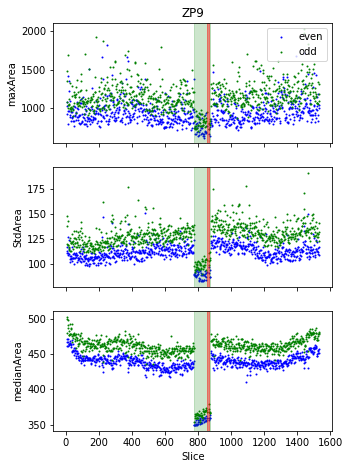

<Figure size 1440x2880 with 0 Axes>

In [115]:
# Alternate version to visualize whether the layer numbers are even or odd - in order to find out whether the
# assumption of different layer behaviour is true 

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize = (5,7.5),sharex=True)
plt.figure(figsize=(20,40))

if num != 2:
    x_varied_max = 875
    x_varied_min = 776

else:
    x_varied_max = 815
    x_varied_min = 716 

# needed to exclude the interruption slices
area_df = area_df[(area_df['Slice_num']>5) & ((area_df['Slice_num']<854) | (area_df['Slice_num']>864))]

# splitting up the dataframe in one with even slice numbers and one with odd slice numbers 
even_area_df = area_df[area_df["Slice_num"]%2 == 0]
odd_area_df = area_df[area_df["Slice_num"]%2 != 0]

ax1.set_title(("ZP{}").format(num))
ax1.scatter(even_area_df["Slice_num"], even_area_df["maxArea"],s=1, color = 'b', label = "even")
ax1.scatter(odd_area_df["Slice_num"], odd_area_df["maxArea"],s=1, color = 'g', label = "odd")
ax1.set_ylabel("maxArea")
ax1.axvspan(x_varied_min, x_varied_max, alpha=0.2, color='green')
ax1.axvspan(854, 864, alpha=0.4, color='red')
leg = ax1.legend(loc='upper right', frameon=True, fancybox=True);

ax2.scatter(even_area_df["Slice_num"], even_area_df["StdArea"],s=1, color = 'b')
ax2.scatter(odd_area_df["Slice_num"], odd_area_df["StdArea"],s=1, color = 'g')
ax2.set_ylabel("StdArea")
ax2.axvspan(x_varied_min, x_varied_max, alpha=0.2, color='green')
ax2.axvspan(854, 864, alpha=0.4, color='red')

ax3.scatter(even_area_df["Slice_num"], even_area_df["medianArea"],s=1, color = 'b')
ax3.scatter(odd_area_df["Slice_num"], odd_area_df["medianArea"],s=1, color = 'g')
ax3.set_ylabel("medianArea")
ax3.set_xlabel("Slice")
ax3.axvspan(x_varied_min, x_varied_max, alpha=0.2, color='green')
ax3.axvspan(854, 864, alpha=0.4, color='red')

fig.savefig(("Grafiken_Flaechenanalyse/ZP{}_area_Untersuchung.png").format(num))

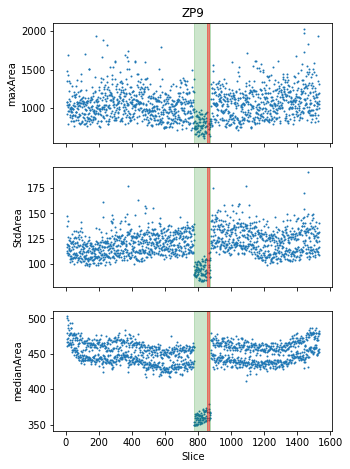

<Figure size 1440x2880 with 0 Axes>

In [31]:
# This block creates a visualization of the maxArea, StdArea and medianArea of the selected tensile test 
# The regions with special parameters are marked as green; the region with the build job interruption is displayed red

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize = (5,7.5),sharex=True)
plt.figure(figsize=(20,40))

if num != 2:
    x_varied_max = 875
    x_varied_min = 776

else:
    x_varied_max = 815
    x_varied_min = 716 

# needed to exclude the interruption slices
area_df = area_df[(area_df['Slice_num']>5) & ((area_df['Slice_num']<854) | (area_df['Slice_num']>864))]

ax1.set_title(("ZP{}").format(num))
ax1.scatter(area_df["Slice_num"], area_df["maxArea"],s=1)
ax1.set_ylabel("maxArea")
ax1.axvspan(x_varied_min, x_varied_max, alpha=0.2, color='green')
ax1.axvspan(854, 864, alpha=0.4, color='red')

ax2.scatter(area_df["Slice_num"], area_df["StdArea"],s=1)
ax2.set_ylabel("StdArea")
ax2.axvspan(x_varied_min, x_varied_max, alpha=0.2, color='green')
ax2.axvspan(854, 864, alpha=0.4, color='red')

ax3.scatter(area_df["Slice_num"], area_df["medianArea"],s=1)
ax3.set_ylabel("medianArea")
ax3.set_xlabel("Slice")
ax3.axvspan(x_varied_min, x_varied_max, alpha=0.2, color='green')
ax3.axvspan(854, 864, alpha=0.4, color='red')

fig.savefig(("Grafiken_Flaechenanalyse/ZP{}_area_Untersuchung.png").format(num))

In [327]:
selected_df = area_df[(area_df['Slice_num']<854) | (area_df['Slice_num']>864)]

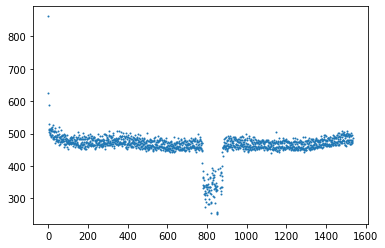

In [331]:
plt.scatter(selected_df["Slice_num"], selected_df["medianArea"],s=1)
plt.show()

In [124]:
minX, minY, maxX, maxY = get_min_max_values_xy_changed_small_diameter (h5_path, part_name,  0, 1593)

In [125]:
area_df[area_df['maxArea']>3000]

,Slice_num,maxArea,medianArea,meanArea,StdArea
393,394.0,3037.0,458.0,465.299366,181.896329
785,786.0,3348.0,315.0,331.804239,234.750805
789,790.0,3065.0,298.0,324.462355,255.600863
793,794.0,5164.0,318.0,330.737051,253.164007
800,801.0,3695.0,374.0,380.123214,225.647220
803,804.0,5032.0,282.0,340.749260,326.203905
804,805.0,3476.0,360.0,399.589754,295.889252
805,806.0,3281.0,320.0,334.992551,244.206281
806,807.0,3499.0,336.0,357.467286,246.076246
810,811.0,3490.0,322.0,354.734883,278.916049


In [140]:
num_slice = 858

array = getting_2D_data_from_h5_filtered_np_xy_switched_without_intensity_filter(h5_path, part_name, 'Slice' + str("{:05d}".format(num_slice)), show_info = True)
array_docked = dock_array_to_zero(array, minX, minY)

16020 total data points found
10437 data points where area != 0 AND intensity != 0
9796 unique x,y-combinations where area != 0 AND intensity != 0
vor iterieren 0.024204730987548828 seconds ---
array creation took 0.05314183235168457 seconds ---


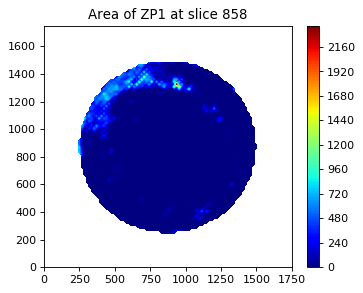

In [141]:
# This block of code displays the Area data of a single slice and interpolates the missing areas for better visualization 

from scipy import ndimage
from scipy.interpolate import griddata
from matplotlib.pyplot import figure

figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k')

x = array_docked[:,0]
y = array_docked[:,1]
z = array_docked[:,2]

xi = np.linspace(0,1750,100)
yi = np.linspace(0,1750,100)
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')
cntr1 = plt.contourf(xi, yi, zi, levels=200, cmap="jet")
plt.title(("Area of ZP{} at slice {}").format(num, num_slice))
plt.colorbar()
plt.show

plt.savefig(("Grafiken_Flaechenanalyse/Area of ZP{} at slice {}.png").format(num, num_slice))

In [281]:
(area_df.index < 853) & (area_df.index > 863 )

array([False, False, False, ..., False, False, False])

In [296]:
area_df[(area_df.index < 853) | (area_df.index > 863 )]["maxArea"]

0       1760
1       1138
2       1835
3       1044
4       1391
        ... 
1528    1823
1529    1111
1530    1164
1531    1153
1532    1179
Name: maxArea, Length: 1522, dtype: object

In [288]:
area_df[(area_df.index > 853) & (area_df.index < 863 )]

,Slice_num,maxArea,medianArea,meanArea,StdArea
854,00855,2516,4.0,170.490244,322.130267
855,00856,1646,0.0,54.105338,164.005088
856,00857,3344,0.0,74.624503,234.071471
857,00858,2372,0.0,41.581462,161.897281
858,00859,1613,461.0,469.918419,181.291573
859,00860,1931,437.0,454.129915,245.049431
860,00861,2892,471.0,499.012661,269.105792
861,00862,1664,383.0,382.225622,208.517530
862,00863,2691,428.0,476.764141,311.862813


In [36]:
area_df[area_df["Slice_num"]%2 == 0]

,Slice_num,maxArea,medianArea,meanArea,StdArea
5,6.0,921.0,461.0,447.690570,112.969023
7,8.0,1079.0,467.0,457.207043,117.133646
9,10.0,1036.0,471.0,461.532980,110.815680
11,12.0,796.0,462.0,451.756926,108.852595
13,14.0,963.0,472.0,464.634956,110.337469
...,...,...,...,...,...
1523,1524.0,1185.0,454.0,442.649482,111.739726
1525,1526.0,917.0,456.0,445.041856,115.820945
1527,1528.0,832.0,451.0,437.958140,109.485682
1529,1530.0,1048.0,457.0,445.765123,108.945430


In [37]:
area_df[area_df["Slice_num"]%2 != 0]

,Slice_num,maxArea,medianArea,meanArea,StdArea
6,7.0,1352.0,503.0,510.880619,147.272227
8,9.0,1076.0,480.0,480.460617,119.364830
10,11.0,1483.0,500.0,507.826262,137.347707
12,13.0,1046.0,491.0,490.774231,118.735627
14,15.0,1010.0,487.0,489.209482,118.732536
...,...,...,...,...,...
1524,1525.0,1054.0,470.0,469.951749,130.126931
1526,1527.0,1936.0,479.0,481.112424,126.570418
1528,1529.0,1094.0,478.0,481.931085,122.902441
1530,1531.0,1191.0,482.0,485.523699,131.289892


In [ ]:
num = int(input("Enter a number: "))
if (num % 2) == 0:
   print("{0} is Even".format(num))
else:
   print("{0} is Odd".format(num))